# Regresión logística

Resumen: 
+ Análisis exploratorio de los datos
+ La selección de variables del dataset para el modelo logístico
+ Implementar una regresión logística con Python
+ Validación del modelo y evaluación del mismo
+ Validación cruzada
+ Matrices de confusión y curvas ROC
+ Resumen final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv("./data/bank/bank.csv", sep=";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
data.shape

(4119, 21)

In [4]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

En nuestro dataset, la variable "target" es **"y"**, que nos indica si el cliente finalmente compró el depósito o no. Vamos a comprobar qué valores tiene actualente:

In [5]:
data["y"].unique()

array(['no', 'yes'], dtype=object)

Podemos comprobar que contiene valores de "yes" o "no", por lo que para nuestro modelo tenemos que convertirlo a numérico (0 y 1).

In [6]:
# Convertimos la variable "y" en numérica (1 - True, 0 - False)
data["y"] = (data["y"]=="yes").astype(int)

In [7]:
data["y"].sample(10)

347     0
3271    1
2879    0
1415    0
40      0
3144    0
2095    0
2608    0
2252    0
2550    0
Name: y, dtype: int32

La variable **`education`** es una de las variables categóricas más importantes a la hora de decidir si compras o no un producto de inversión. Veamos qué valores contiene:

In [8]:
data["education"].unique()

array(['basic.9y', 'high.school', 'university.degree',
       'professional.course', 'basic.6y', 'basic.4y', 'unknown',
       'illiterate'], dtype=object)

Vamos a intentar agruparlos para que sean más coherentes. Vamos a agrupar los que comienzan por "basic" en un único grupo, por ejemplo. Y el resto de valores vamos a nombrarlos de una forma más adecuada.

In [9]:
data["education"] = np.where(data["education"]=="basic.4y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.6y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.9y", "Basic", data["education"])

data["education"] = np.where(data["education"]=="high.school", "High School", data["education"])
data["education"] = np.where(data["education"]=="professional.course", "Professional Course", data["education"])
data["education"] = np.where(data["education"]=="university.degree", "University Degree", data["education"])

data["education"] = np.where(data["education"]=="illiterate", "Illiterate", data["education"])
data["education"] = np.where(data["education"]=="unknown", "Unknown", data["education"])

In [10]:
data["education"].unique()

array(['Basic', 'High School', 'University Degree', 'Professional Course',
       'Unknown', 'Illiterate'], dtype=object)

Bien, ya hemos hecho un poco de limpieza de los datos (data cleaning). Vamos a realizar un análisis exploratorio de los datos (EDA). Vamos a comprobar si vendemos o no vendemos, por lo que contaremos cuántos clientes han contratado el depósito:

In [11]:
data["y"].value_counts()

0    3668
1     451
Name: y, dtype: int64

Vamos a ver la media de aquellas variables numéricas agrupadas por ventas:

In [12]:
data.groupby("y").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
0,39.895311,219.40976,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072
1,41.889135,560.78714,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625


Vamos a agrupar por educación

In [13]:
data.groupby("education").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
education,,,,,,,,,,,
Basic,42.337124,253.898457,2.429732,978.815597,0.149472,0.237368,93.658600,-41.120552,3.775701,5174.133144,0.079610
High School,38.097720,258.534202,2.630836,958.022801,0.206298,-0.002497,93.564314,-40.995765,3.511732,5163.212595,0.105320
Illiterate,42.000000,146.000000,4.000000,999.000000,0.000000,-2.900000,92.201000,-31.400000,0.834000,5076.200000,0.000000
Professional Course,40.207477,278.816822,2.512150,958.211215,0.194393,0.163925,93.599630,-40.127664,3.701426,5167.595140,0.121495
University Degree,39.017405,247.707278,2.583070,947.900316,0.207278,-0.009731,93.499109,-39.830063,3.547132,5163.023180,0.130538
Unknown,42.826347,267.281437,2.538922,939.700599,0.263473,-0.074251,93.637455,-39.487425,3.410174,5151.260479,0.155689


Vamos a visualizar algunos de estos datos:

Text(0,0.5,'Frecuencia de compra del producto')

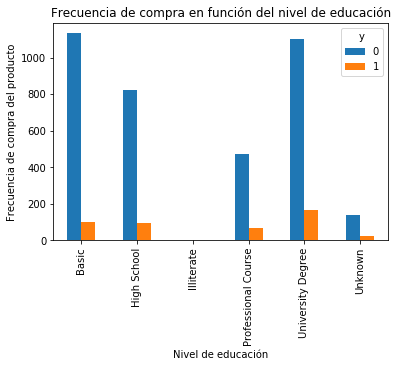

In [14]:
# Vamos a utilizar una tabla cruzada para comparar dos variables (en este caso, Educación y ventas)
pd.crosstab(data.education, data.y).plot(kind="bar")
plt.title("Frecuencia de compra en función del nivel de educación")
plt.xlabel("Nivel de educación")
plt.ylabel("Frecuencia de compra del producto")

In [15]:
pd.crosstab(data.education, data.y)

y,0,1
education,,
Basic,1133,98
High School,824,97
Illiterate,1,0
Professional Course,470,65
University Degree,1099,165
Unknown,141,26


También resulta útil construir un gráfico de barras apiladas acerca del estado civil para ver si influye en la contratación o no del depósito.

Text(0,0.5,'Proporción de clientes')

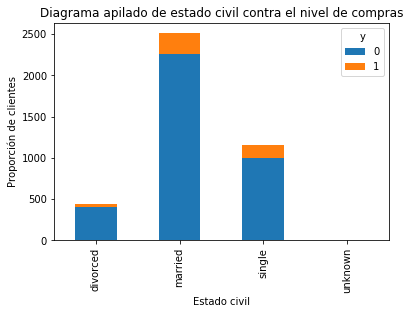

In [16]:
pd.crosstab(data.marital, data.y).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de estado civil contra el nivel de compras")
plt.xlabel("Estado civil")
plt.ylabel("Proporción de clientes")

Para que todas las columnas sean comparables, entre 0 y 1, hacemos lo siguiente:

Text(0,0.5,'Proporción de clientes')

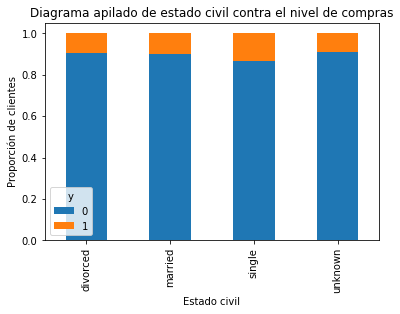

In [17]:
table=pd.crosstab(data.marital, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de estado civil contra el nivel de compras")
plt.xlabel("Estado civil")
plt.ylabel("Proporción de clientes")

Vamos a crear un gráfica entre el día de compra y las ventas, a ver si detectamos alguna tendencia:

Text(0,0.5,'Frecuencia de compra del producto')

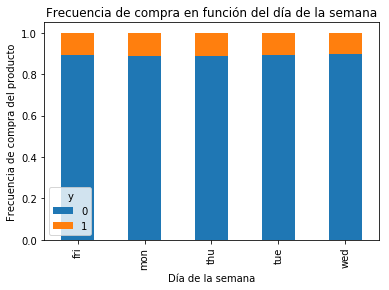

In [18]:
table= pd.crosstab(data.day_of_week, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Frecuencia de compra en función del día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Frecuencia de compra del producto")

Parece que no tiene ninguna influencia el día de la semana. Vamos a comprobar si el mes de la compra tiene alguna tendencia especial:

Text(0,0.5,'Frecuencia de compra del producto')

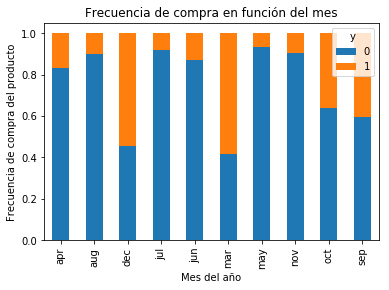

In [19]:
table= pd.crosstab(data.month, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto")

Parece que el mes puede ser un buen predictor. Parece que diciembre y marzo destacan sobre el resto, pero vamos a ver si es porque hay pocos datos.

Text(0,0.5,'Frecuencia de compra del producto')

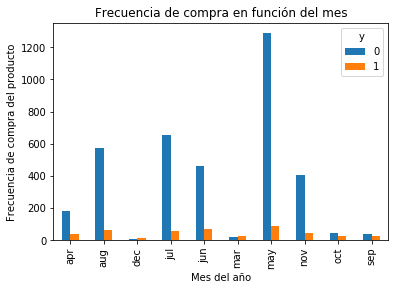

In [20]:
table= pd.crosstab(data.month, data.y).plot(kind="bar")
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto")

Vamos a comprobar si la edad tiene alguna influencia en las ventas:

Text(0,0.5,'Cliente')

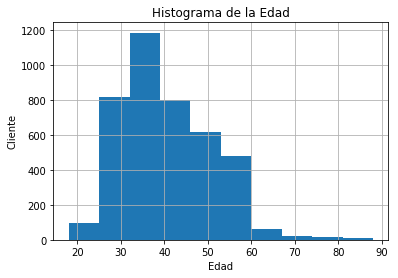

In [21]:
data.age.hist()
plt.title("Histograma de la Edad")
plt.xlabel("Edad")
plt.ylabel("Cliente")

Vemos que la mayoría de la gente está entre 30 y 40 años. Veamos un gráfico comparando la edad con las ventas

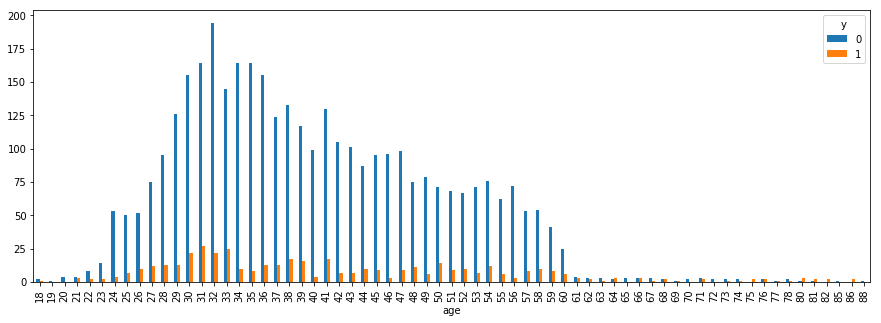

In [22]:
pd.crosstab(data.age, data.y).plot(kind="bar", figsize=(15,5))

Veamos ahora con la variable `poutcome`, que es el resultado de la anterior campaña de márketing.

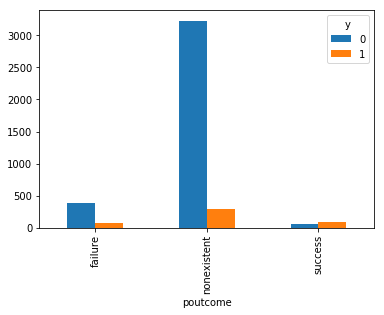

In [23]:
pd.crosstab(data.poutcome, data.y).plot(kind="bar")

Parace que si previamente has contratado es más probable que vuelvas a contratar. Puede ser una buena variable predictora.

Bien, ahora que hemos visto qué variables consideramos que tienen influencia, vamos a llevar a cabo el proceso de creación del modelo logístico para decidir si un cliente contrata o no contrata. Primero tendremos que realizar una limpieza sobre las variables dummies.

## Conversión de las variables categóricas a dummies

Vamos a crear una función que nos convierta todas las variables categóricas a dummies:

In [24]:
categorias = ["job", "marital", "education", "default", "housing", "loan", "contact", 
              "month", "day_of_week", "poutcome"]
for categoria in categorias:
    cat_list = "cat_" + categoria
    cat_dummies = pd.get_dummies(data[categoria], prefix=cat_list)
    data_new = data.join(cat_dummies)
    data = data_new

In [25]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'cat_job_admin.',
       'cat_job_blue-collar', 'cat_job_entrepreneur', 'cat_job_housemaid',
       'cat_job_management', 'cat_job_retired', 'cat_job_self-employed',
       'cat_job_services', 'cat_job_student', 'cat_job_technician',
       'cat_job_unemployed', 'cat_job_unknown', 'cat_marital_divorced',
       'cat_marital_married', 'cat_marital_single', 'cat_marital_unknown',
       'cat_education_Basic', 'cat_education_High School',
       'cat_education_Illiterate', 'cat_education_Professional Course',
       'cat_education_University Degree', 'cat_education_Unknown',
       'cat_default_no', 'cat_default_unknown', 'cat_default_yes',
       'cat_housing_no', 'cat_housing_unknown', 'cat_housing_yes',
       'cat_loa

Vamos a eliminar las columnas categóricas, porque ya no las necesitamos

In [26]:
data_vars = data.columns.values.tolist()
to_keep = [v for v in data_vars if v not in categorias]
to_keep

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y',
 'cat_job_admin.',
 'cat_job_blue-collar',
 'cat_job_entrepreneur',
 'cat_job_housemaid',
 'cat_job_management',
 'cat_job_retired',
 'cat_job_self-employed',
 'cat_job_services',
 'cat_job_student',
 'cat_job_technician',
 'cat_job_unemployed',
 'cat_job_unknown',
 'cat_marital_divorced',
 'cat_marital_married',
 'cat_marital_single',
 'cat_marital_unknown',
 'cat_education_Basic',
 'cat_education_High School',
 'cat_education_Illiterate',
 'cat_education_Professional Course',
 'cat_education_University Degree',
 'cat_education_Unknown',
 'cat_default_no',
 'cat_default_unknown',
 'cat_default_yes',
 'cat_housing_no',
 'cat_housing_unknown',
 'cat_housing_yes',
 'cat_loan_no',
 'cat_loan_unknown',
 'cat_loan_yes',
 'cat_contact_cellular',
 'cat_contact_telephone',
 'cat_month_apr',
 'cat_month_aug',
 'cat_month_dec',
 'cat_month_jul',
 'cat

In [27]:
bank_data = data[to_keep]
bank_data.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'cat_job_admin.', 'cat_job_blue-collar', 'cat_job_entrepreneur',
       'cat_job_housemaid', 'cat_job_management', 'cat_job_retired',
       'cat_job_self-employed', 'cat_job_services', 'cat_job_student',
       'cat_job_technician', 'cat_job_unemployed', 'cat_job_unknown',
       'cat_marital_divorced', 'cat_marital_married',
       'cat_marital_single', 'cat_marital_unknown', 'cat_education_Basic',
       'cat_education_High School', 'cat_education_Illiterate',
       'cat_education_Professional Course',
       'cat_education_University Degree', 'cat_education_Unknown',
       'cat_default_no', 'cat_default_unknown', 'cat_default_yes',
       'cat_housing_no', 'cat_housing_unknown', 'cat_housing_yes',
       'cat_loan_no', 'cat_loan_unknown', 'cat_loan_yes',
       'cat_contact_cellular', 'cat_contact_telephone', 'cat_month_apr',

In [28]:
# Vamos a crear las listas con la variable a predecir y las variables predictoras
bank_data_vars = bank_data.columns.values.tolist()
Y = ['y']
X = [v for v in bank_data_vars if v not in Y]

### Selección de rasgos para el modelo

Vamos a seleccionar qué variables son más significativas para predecir el valor de salida del modelo

In [29]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [30]:
# Nº de variables a seleccionar
n = 12

In [31]:
lr = LogisticRegression()

In [32]:
rfe = RFE(lr, n)
rfe = rfe.fit(bank_data[X], bank_data[Y].values.ravel())

In [33]:
rfe

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=12, step=1, verbose=0)

In [34]:
# Para ver qué variable se han seleccionado para el modelo
print(rfe.support_)

[False False False False  True False False False  True False False False
  True False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True False  True False False False False False False  True False
  True]


In [35]:
# Vamos a mostrar un ranking para ver qué variables son más probables que se queden en el modelo
print(rfe.ranking_)

[36 42 18 44  1 14 30 29  1 39 23  3  1 38  2 40  1  5 32 34 12 47 19 43
 33 50 31 13 48 22 41  8 37 35 49 20  6 10 15  9 24 16  4 45 25  1  1  1
  1  1 17  1 46 26 21 28 27 11  1  7  1]


In [36]:
# Vamos a mostrar qué variables ha seleccionado
z=zip(bank_data_vars, rfe.support_, rfe.ranking_)
list(z)

[('age', False, 36),
 ('duration', False, 42),
 ('campaign', False, 18),
 ('pdays', False, 44),
 ('previous', True, 1),
 ('emp.var.rate', False, 14),
 ('cons.price.idx', False, 30),
 ('cons.conf.idx', False, 29),
 ('euribor3m', True, 1),
 ('nr.employed', False, 39),
 ('y', False, 23),
 ('cat_job_admin.', False, 3),
 ('cat_job_blue-collar', True, 1),
 ('cat_job_entrepreneur', False, 38),
 ('cat_job_housemaid', False, 2),
 ('cat_job_management', False, 40),
 ('cat_job_retired', True, 1),
 ('cat_job_self-employed', False, 5),
 ('cat_job_services', False, 32),
 ('cat_job_student', False, 34),
 ('cat_job_technician', False, 12),
 ('cat_job_unemployed', False, 47),
 ('cat_job_unknown', False, 19),
 ('cat_marital_divorced', False, 43),
 ('cat_marital_married', False, 33),
 ('cat_marital_single', False, 50),
 ('cat_marital_unknown', False, 31),
 ('cat_education_Basic', False, 13),
 ('cat_education_High School', False, 48),
 ('cat_education_Illiterate', False, 22),
 ('cat_education_Professional

Por tanto, vamos a crear los dos dataframes en función del resultado obtenido:

In [37]:
# Primero vamos a extraer las columnas seleccionadas 
cols = [x for x, y in zip(bank_data, rfe.support_) if y]

# Creamos los dataframes
X = bank_data[cols]
Y = bank_data["y"]

### Implementación del modelo en Python con statsmodel.api

In [38]:
import statsmodels.api as sm

In [39]:
logit_model = sm.Logit(Y, X)

In [40]:
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.291770
         Iterations 7


In [41]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                  Logit              Pseudo R-squared:   0.155     
Dependent Variable:     y                  AIC:                2427.6025 
Date:                   2019-01-27 21:02   BIC:                2503.4828 
No. Observations:       4119               Log-Likelihood:     -1201.8   
Df Model:               11                 LL-Null:            -1422.9   
Df Residuals:           4107               LLR p-value:        6.4492e-88
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         7.0000                                           
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
previous                 -0.1229   0.0700  -1.7545 0.0793 -0.2601  0.0144
euribor3m                -0.6049   0.0383 -15.7882 0.0000 -0.6800 -0.5298
cat_job_blue-collar      -0.5032   0.1519  -3.3136 0.0009 -0.8009 -0.2056
cat_job_retired           0.2235   0.2191   1.0205 0.3075 -0.2058  0.6529
cat_month_aug             0.6048   0.1759   3.4374 0.0006  0.2600  0.9497
cat_month_dec             1.1358   0.4493   2.5281 0.0115  0.2552  2.0163
cat_month_jul             1.0327   0.1910   5.4071 0.0000  0.6584  1.4070
cat_month_jun             1.0775   0.1752   6.1493 0.0000  0.7341  1.4210
cat_month_mar             1.6448   0.3139   5.2407 0.0000  1.0297  2.2600
cat_month_nov             0.3828   0.1950   1.9634 0.0496  0.0007  0.7649
cat_day_of_week_wed      -0.0649   0.1391  -0.4665 0.6409 -0.3375  0.2077
cat_poutcome_nonexistent -0.7753   0.1221  -6.3492 0.0000 -1.0147 -0.5360
=========================================================================

"""

### Implementación del modelo en Python con scikit-learn

In [42]:
from sklearn import linear_model

In [43]:
logit_model = linear_model.LogisticRegression()
logit_model.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
logit_model.score(X,Y)

0.8963340616654528

In [45]:
# Qué porcentaje compra
1-Y.mean()

0.8905074047098811

In [46]:
# Vamos a listar los coeficientes asociados a cada variabble predictora
pd.DataFrame(list(zip(X.columns, np.transpose(logit_model.coef_))))

,0,1
0,previous,[0.5076571351686332]
1,euribor3m,[-0.546496137304835]
2,cat_job_blue-collar,[-0.35915536241326046]
3,cat_job_retired,[0.35603838871464233]
4,cat_month_aug,[0.6253983084501036]
5,cat_month_dec,[1.182217298590346]
6,cat_month_jul,[0.9622633624910251]
7,cat_month_jun,[1.054317924650511]
8,cat_month_mar,[1.630636629761289]
9,cat_month_nov,[0.45195768167641753]


Vemos pues que las variables más determinantes son **cat_month_dec**, **cat_month_jun** y **cat_month_mar**. 

## Validación del modelo logístico

Lo habitual es dividir nuestro dataset en dos: entrenamiento y testing

In [47]:
from IPython.display import display, Math, Latex, Image
from sklearn.model_selection import train_test_split

In [48]:
# 70% entrenamiento, 30% testing
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=0)

lm = linear_model.LogisticRegression()
lm.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

La ecuación que sustenta el modelo lleva a cabo la predicción de las probabilidades, no de las clases. Una vez que tenemos el modelo creado, necesitamos definir un umbral a partir del cual estas probabilidades van a ser clasificadas en dos categorías. Si la probabilidad es inferior a ese umbral entonces se considerará como 0 (no contrata el depósito, en nuestro ejemplo) y si es mayor se considerará como 1 (contrata el depósito). Este el objetivo de utilizar una regresión logística.

In [49]:
display(Math(r'Y_p=\begin{cases}0& si\ p\leq0.5\\1&si\ p >0.5\end{cases}'))

<IPython.core.display.Math object>

Vamos a obtener las probabilidades a partir del modelo:

In [50]:
probs = lm.predict_proba(X_test)
probs

array([[0.95462912, 0.04537088],
       [0.83762689, 0.16237311],
       [0.93244632, 0.06755368],
       ...,
       [0.65044409, 0.34955591],
       [0.97383524, 0.02616476],
       [0.57021896, 0.42978104]])

La primera columna es la probabilidad (cómo de seguro estoy de lo que estoy diciendo) y la segunda columna es la probabilidad del valor de salida (en nuestro ejemplo, la contratación o no del depósito). Por defecto, si la probabilidad es superior a 0.5 el resultado se cataloga como positivo (contratación del depósito). Si es menor que 0.5 será catalogada como negativa (no contratación)

In [51]:
# Vamos a realizar la predicción con el conjunto de test
prediction = lm.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
# Desde un punto de vista general
display(Math(r'\varepsilon\in (0,1), Y_p=\begin{cases}0& si\ p\leq \varepsilon\\1&si\ p >\varepsilon\end{cases}'))

<IPython.core.display.Math object>

Es decir, podemos definir un umbral personalizado. En nuestro caso, tenemos sólo un 10% de clientes que contratan el producto, entonces establecer el umbral en 0.10 puede ser una buena decisión.

In [53]:
# Nos quedamos sólo con la columna de probabilidad (la segunda columna)
prob = probs[:,1]
# Creamos un df sólo con esa columna
prob_df = pd.DataFrame(prob)
# Definimos el umbral
threshold = 0.1
# Creamos un columna llamadas "prediction", con el resultado de aplicar el umbral a la predicción, es decir 0 si es menor/igual y 1 si es mayor
prob_df["prediction"] = np.where(prob_df[0]>threshold, 1, 0)
prob_df.head()

,0,prediction
0,0.045371,0
1,0.162373,1
2,0.067554,0
3,0.062144,0
4,0.041582,0


In [54]:
pd.crosstab(prob_df.prediction, columns="count")

col_0,count
prediction,
0,846
1,390


In [55]:
# Porcentaje de contrataciones
390/len(prob_df)*100

31.55339805825243

In [56]:
# Si elegimos un umbral algo mayor
threshold = 0.15
prob_df["prediction"] = np.where(prob_df[0]>threshold, 1, 0)
pd.crosstab(prob_df.prediction, columns="count")

col_0,count
prediction,
0,905
1,331


In [57]:
# Porcentaje de contrataciones
331/len(prob_df)*100

26.779935275080906

In [58]:
threshold = 0.05
prob_df["prediction"] = np.where(prob_df[0]>threshold, 1, 0)
pd.crosstab(prob_df.prediction, columns="count")

col_0,count
prediction,
0,504
1,732


In [59]:
# Porcentaje de contrataciones
732/len(prob_df)*100

59.22330097087378

In [60]:
from sklearn import metrics

In [61]:
# Porcentaje de precisión del modelo
metrics.accuracy_score(Y_test, prediction)

0.9004854368932039

## Validación cruzada

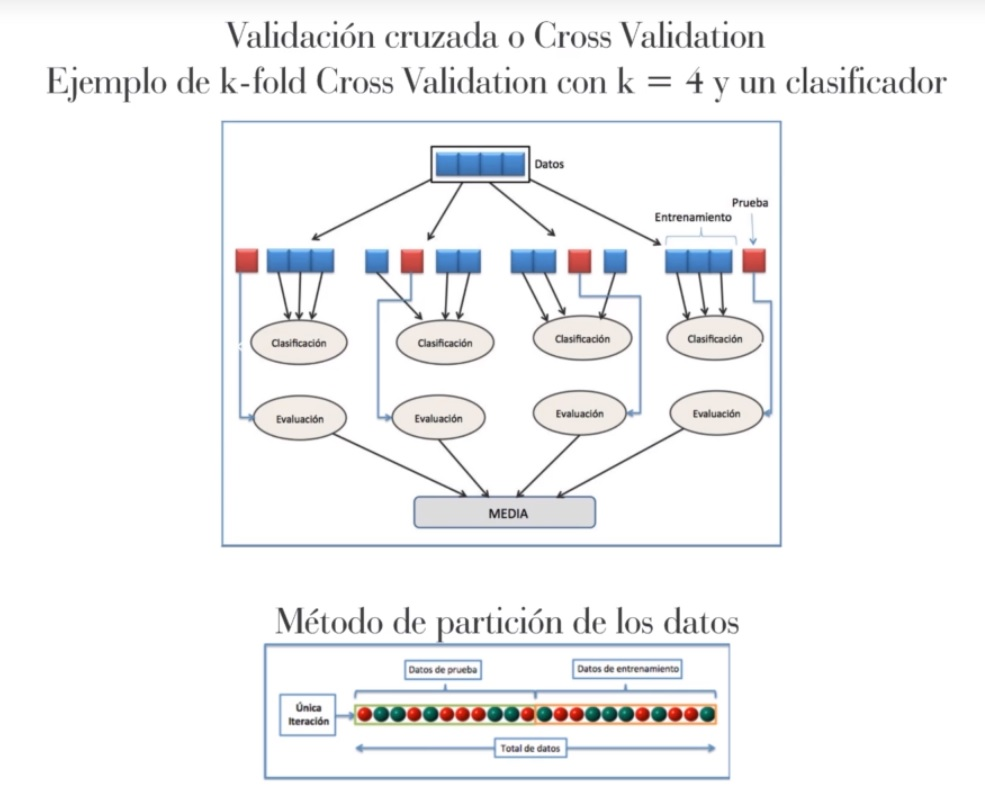

In [62]:
Image(filename="./images/crossvalidation_01.jpg")

Cross Validation consiste en partir los datos repetidas veces y calcular la media aritmética obtenida de las medias de evaluación sobre diferentes particiones llevadas a cabo. Se utiliza en entornos donde el objetivo principal es predecir los datos pero también se usa en el caso de clasificadores.

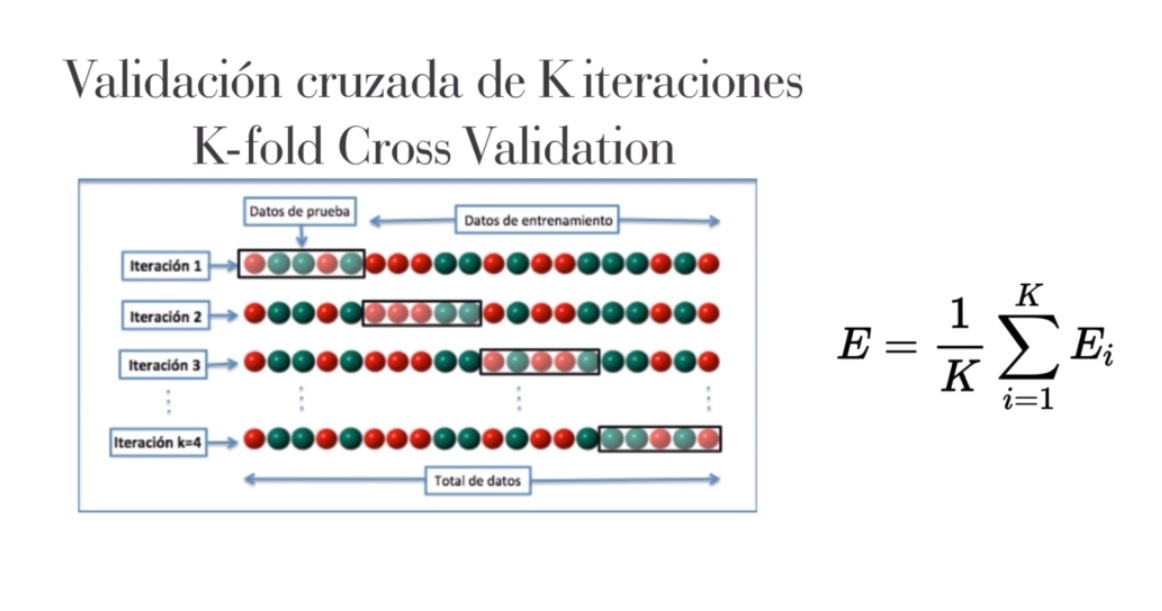

In [63]:
Image(filename="./images/crossvalidation_02.jpg")

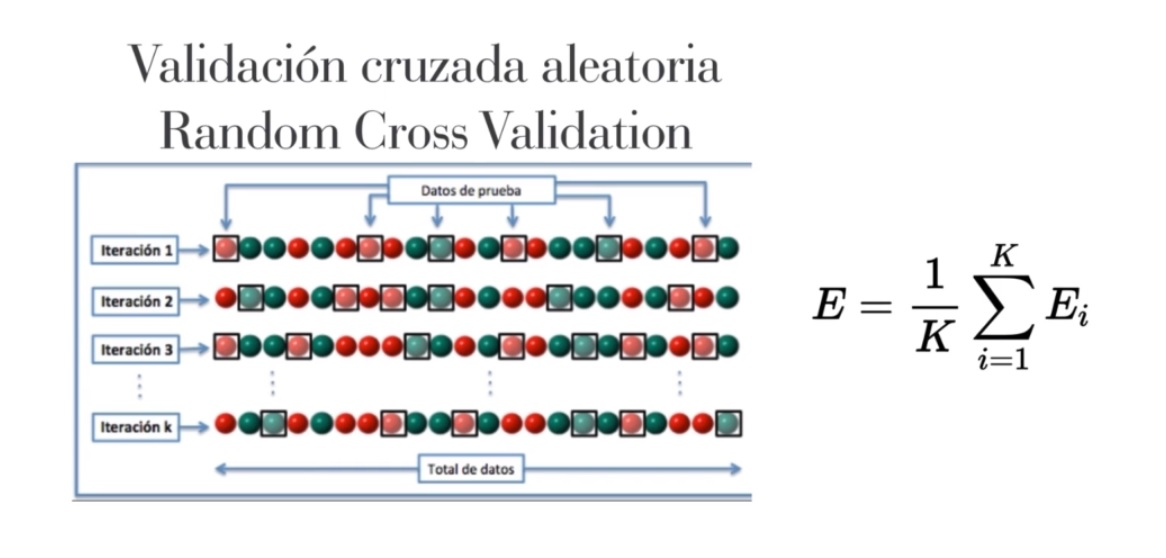

In [64]:
Image(filename="./images/crossvalidation_03.jpg")

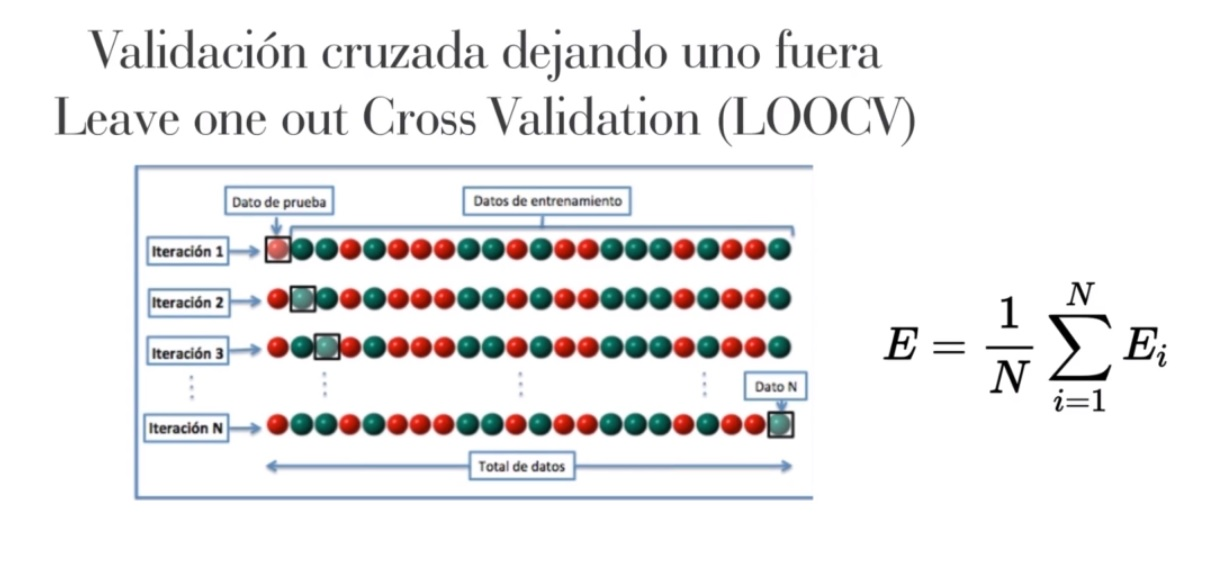

In [65]:
Image(filename="./images/crossvalidation_04.jpg")

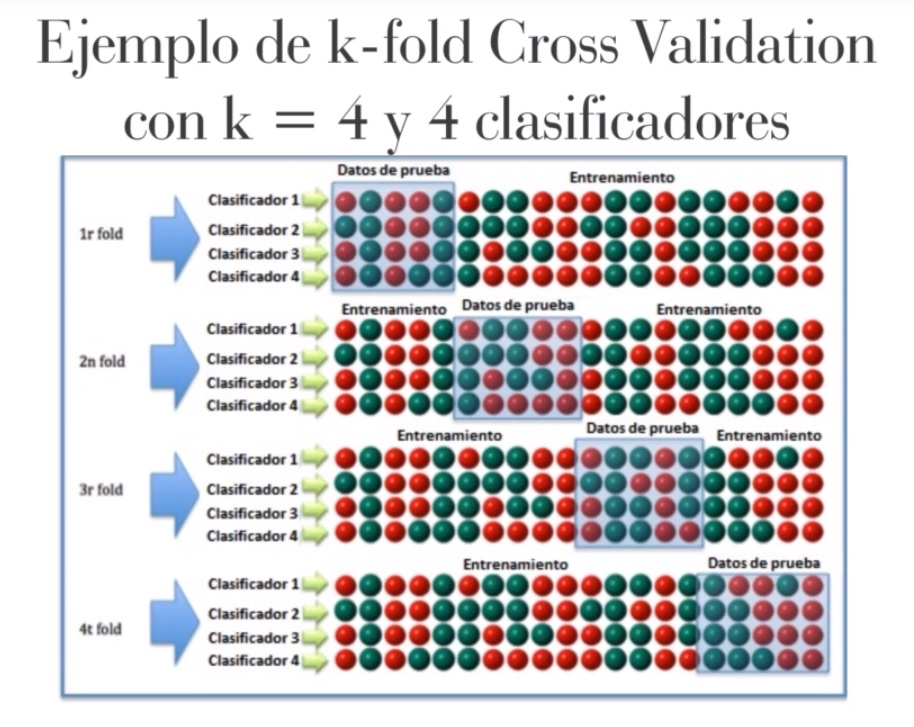

In [66]:
Image(filename="./images/crossvalidation_05.jpg")

La técnica denominada **validación cruzada (cross validation)** se lleva a cabo en el dataset cuando intentamos hacer una predicción para comprobar cómo de bien el modelo es capaz de generalizar los resultados, de modo que sea independiente del dataset utilizado. La validación cruzada se requiere en muchos casos para hacer que el modelo predictivo no sufra de *overfitting* (que se ajuste demasiado bien a los datos utilizados para el modelo y se comporte mal para el resto).

In [67]:
from sklearn.model_selection import cross_val_score

In [68]:
scores = cross_val_score(linear_model.LogisticRegression(), X, Y, scoring="accuracy", cv=10)  # cv = número de divisiones para cross validation
scores

array([0.9031477 , 0.88834951, 0.90533981, 0.89563107, 0.90048544,
       0.8907767 , 0.88349515, 0.89320388, 0.89537713, 0.88807786])

In [69]:
# Vamos a ver el promedio de las predicciones
scores.mean()

0.8943884240990478

Es interesante consultar la entrada de Validación Cruzada en [Wikipedia](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada)

## Matrices de confusión y curvas ROC

[Link interesante](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

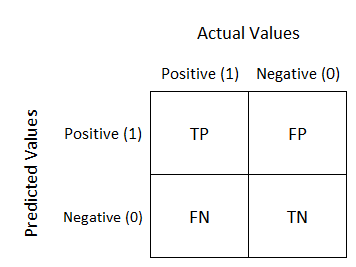

In [70]:
Image(filename="./images/matriz_confusion_00.png")

**Interpretación de la matriz de confusión**:
+ **TP - Verdadero positivo**: Predicción correcta del positivo. Era positivo y la predicción ha sido positiva
+ **TN - Verdadero negativo**: Predicción correcta del negativo. Era negativo y la predicción ha sido negativa
+ **FN - Falso positivo**: Predicción incorrecta del positivo. Era positivo y la predicción ha sido negativa
+ **FP - Falso negativo**: Predicción incorrecta del negativo. Era negativo y la predicción ha sido positiva


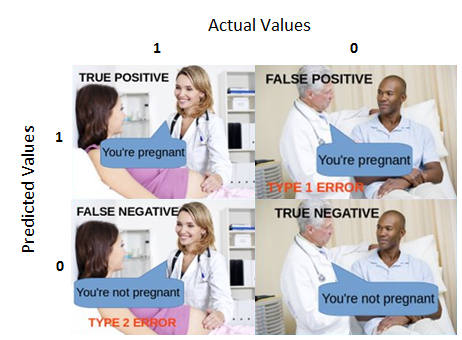

In [71]:
Image(filename="./images/matriz_confusión_example.png")

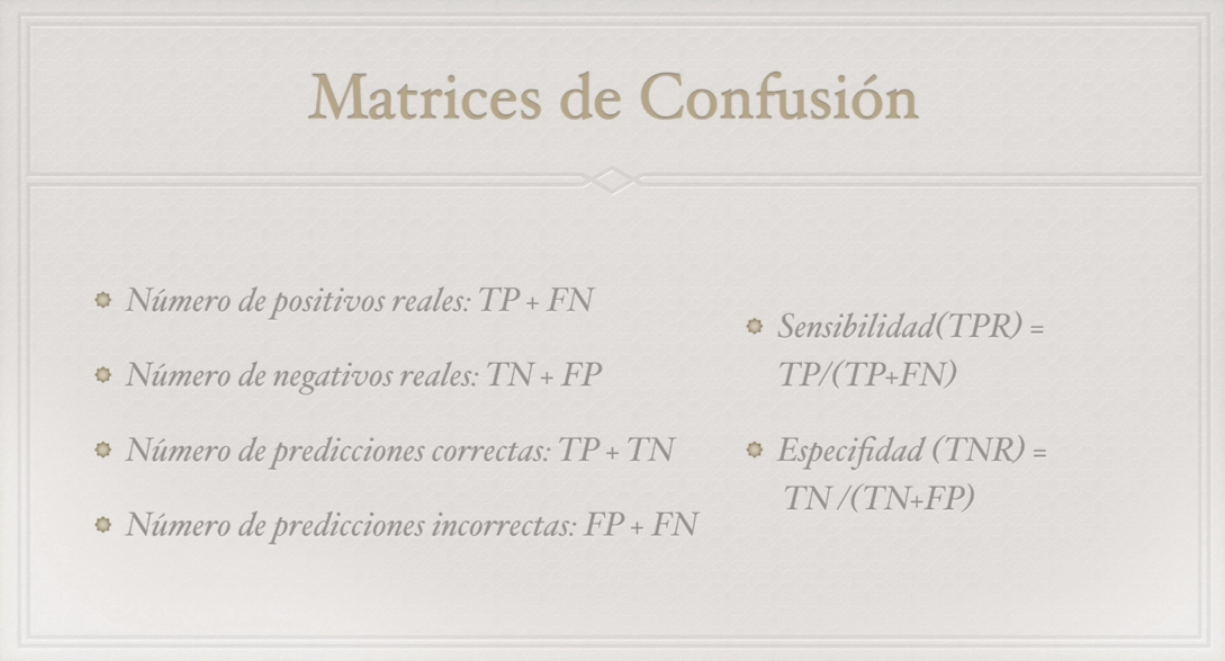

In [72]:
Image(filename="./images/matrices_confusion_02.png")

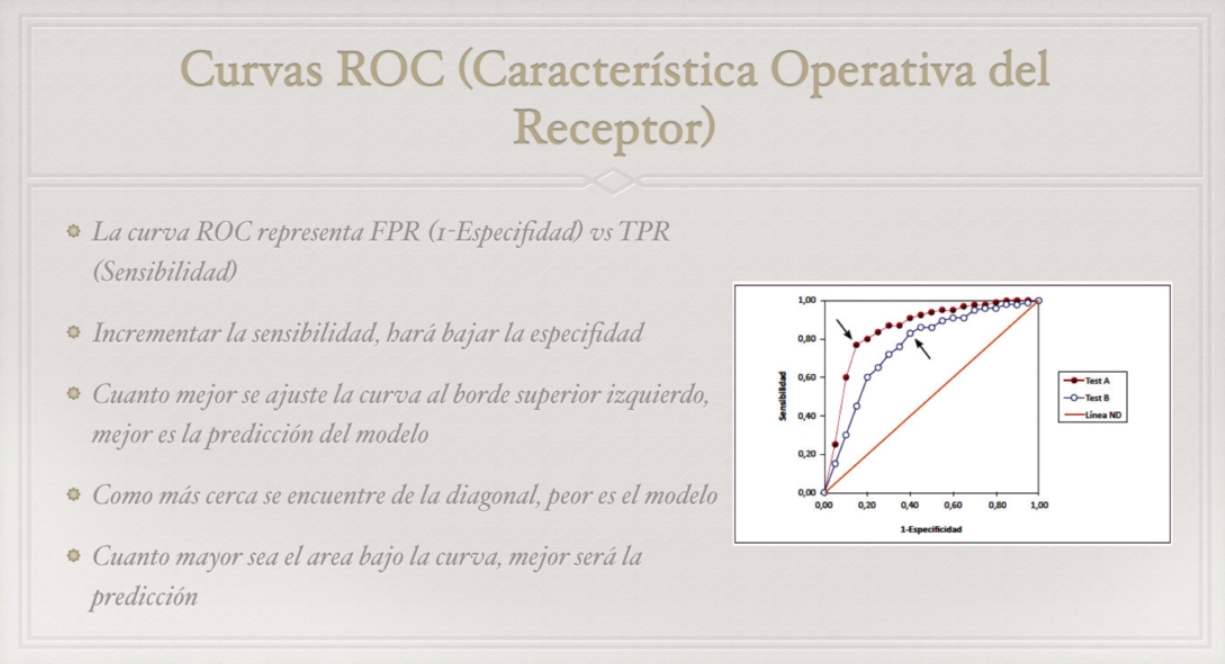

In [73]:
Image(filename="./images/matrices_confusion_03.png")

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3, random_state=0)
lm = linear_model.LogisticRegression()
lm.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
probs = lm.predict_proba(X_test)

prob=probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1
prob_df["prediction"] = np.where(prob_df[0]>=threshold, 1, 0)
prob_df["actual"] = list(Y_test)
prob_df.head()

,0,prediction,actual
0,0.045371,0,0
1,0.162373,1,0
2,0.067554,0,0
3,0.062144,0,0
4,0.041582,0,0


In [76]:
confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
confusion_matrix

actual,0,1
prediction,,
0,806,40
1,308,82


In [77]:
TN=confusion_matrix[0][0]
TP=confusion_matrix[1][1]
FN=confusion_matrix[0][1]
FP=confusion_matrix[1][0]

In [78]:
# Calculamos la sensibilidad
sensibilidad = TP/(TP+FN)
sensibilidad

0.21025641025641026

In [79]:
# Calculamos la especificidad. 1-especifidad es para que la curva ROC quede en la forma a la que estamos acostumbrados a analizarla.
especificidad_1 = 1-TN/(TN+FP)
especificidad_1

0.047281323877068515

Vamos a calcular ambos parámetros pero para diferentes valores del umbral (threshold)

In [80]:
thresholds = [0.04, 0.05, 0.07, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.3, 0.4, 0.5]
sensitivities = [1]
especifities_1 = [1]

for t in thresholds:
    prob_df["prediction"] = np.where(prob_df[0]>=t, 1, 0)
    prob_df["actual"] = list(Y_test)

    confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
    TN=confusion_matrix[0][0]
    TP=confusion_matrix[1][1]
    FP=confusion_matrix[0][1]
    FN=confusion_matrix[1][0]
    
    sens = TP/(TP+FN)
    sensitivities.append(sens)
    espc_1 = 1-TN/(TN+FP)
    especifities_1.append(espc_1)

sensitivities.append(0)
especifities_1.append(0)

In [81]:
sensitivities

[1,
 0.9344262295081968,
 0.8442622950819673,
 0.680327868852459,
 0.6721311475409836,
 0.6639344262295082,
 0.6475409836065574,
 0.5163934426229508,
 0.45901639344262296,
 0.4016393442622951,
 0.36065573770491804,
 0.1721311475409836,
 0.11475409836065574,
 0]

In [82]:
especifities_1

[1,
 0.7782764811490126,
 0.5646319569120287,
 0.2989228007181328,
 0.2764811490125674,
 0.24596050269299818,
 0.22621184919210058,
 0.12387791741472176,
 0.1077199281867145,
 0.07181328545780974,
 0.06463195691202872,
 0.02333931777378817,
 0.013464991023339312,
 0]

Text(0.5,1,'Curva ROC')

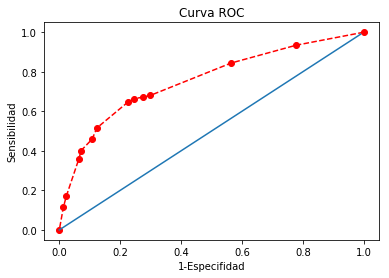

In [83]:
plt.plot(especifities_1, sensitivities, marker="o", linestyle="--", color="r")
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especifidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")

In [84]:
from sklearn import metrics
from ggplot import *

c:\program files\python37\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [85]:
espc_1, sensit, _ = metrics.roc_curve(Y_test, prob)  # Nos devuelve un tercer valor que no vamos a utilizar

In [86]:
df = pd.DataFrame({
    "esp":espc_1,
    "sens":sensit
})
df.head()

,esp,sens
0,0.000000,0.008197
1,0.000000,0.024590
2,0.000000,0.032787
3,0.002693,0.032787
4,0.002693,0.049180


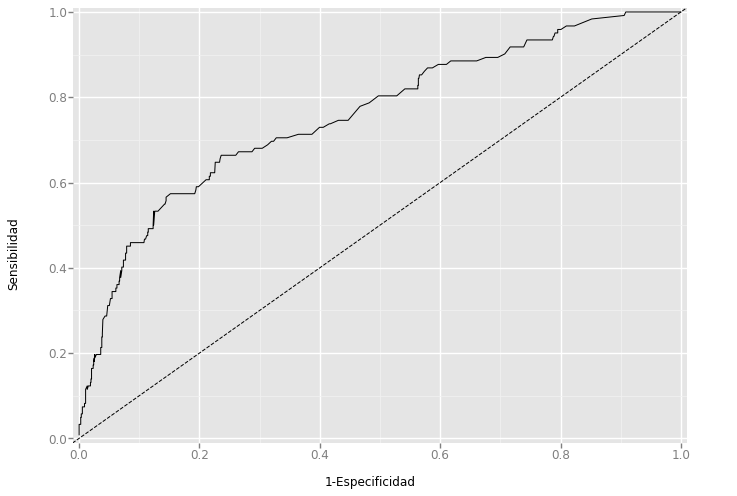

<ggplot: (169398659967)>

In [87]:
ggplot(df, aes(x="esp", y="sens")) + \
       geom_line() + geom_abline(linetype="dashed")+ \
       xlim(-0.01,1.01) + ylim(-0.01,1.01) + xlab("1-Especificidad") + ylab("Sensibilidad")

Vamos a calcular el área debajo de la curva (area under curve - AUC)

In [88]:
auc = metrics.auc(espc_1, sensit)
auc

0.7575712982311564

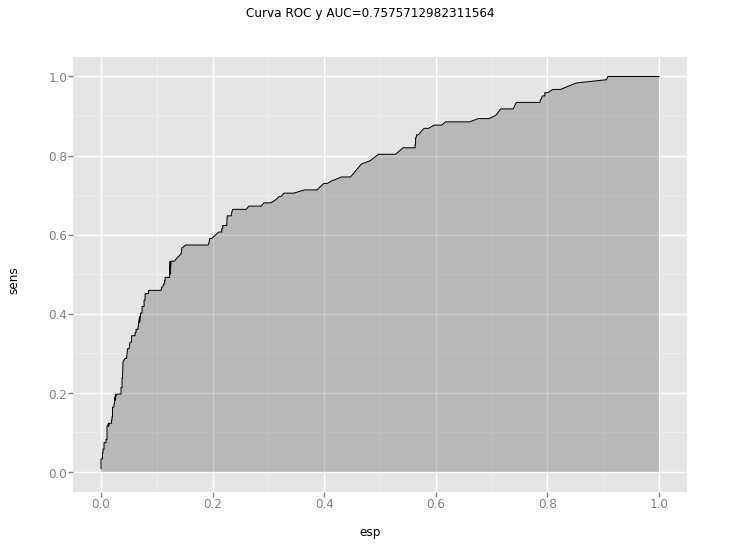

<ggplot: (169398690361)>

In [89]:
ggplot(df, aes(x="esp", y="sens")) + \
       geom_area(alpha=0.25) + \
       geom_line(aes(y="sens")) + \
       ggtitle("Curva ROC y AUC=%s"%str(auc))

## Resumen final

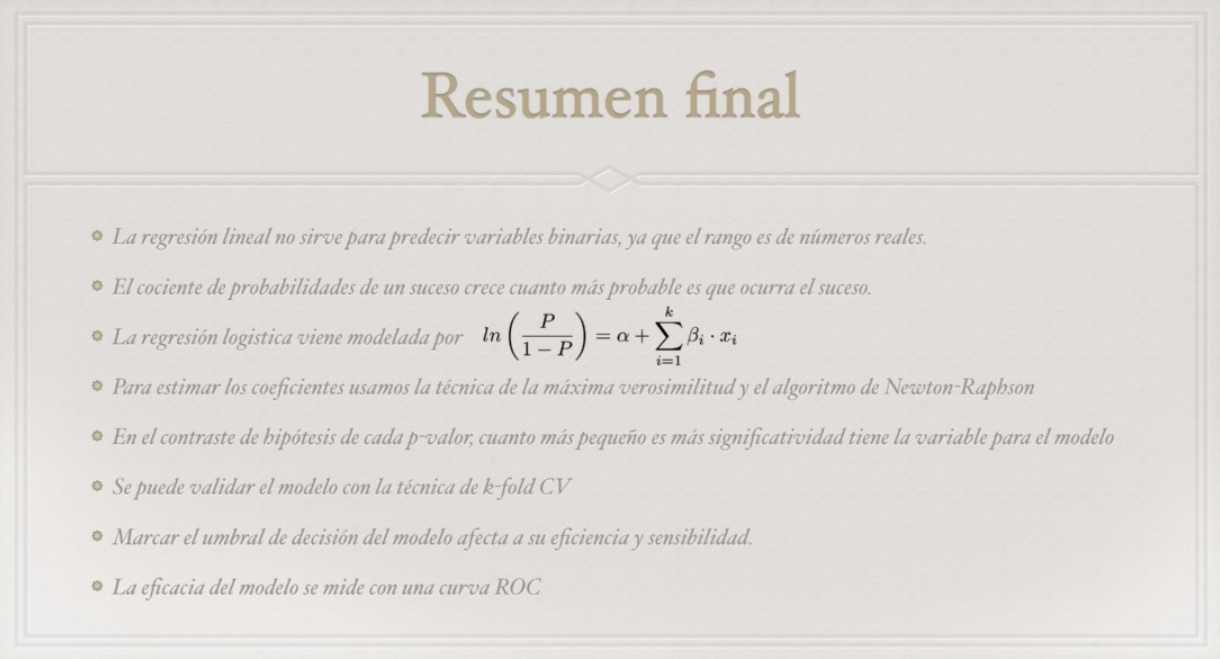

In [90]:
Image(filename="./images/regresion_logistica_res_01.png")